In [43]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import sys
from termcolor import colored
from scipy.optimize import newton

<div class="alert alert-success" align="center"><b> Formulaires</b></div>

Couches de choc minces :
------------------------
$$\frac{\tan(\sigma - \theta)}{\tan(\sigma)} = \frac{\rho_0}{\rho_1} = \frac{\gamma - 1}{\gamma + 1} + \frac{2}{(\gamma + 1)M^{2}_{0}\sin(\sigma)^2}$$

Relations isentropiques pour un gaz compressible :
--------------------------------------------------

$$\frac{T_i}{T} = 1 + \frac{\gamma-1}{2} M^2$$

$$\frac{p_i}{p} = \left(1 + \frac{\gamma-1}{2} M^2\right)^{\frac{\gamma}{\gamma - 1}}$$

$$\frac{\rho_i}{\rho} = \left(1 + \frac{\gamma-1}{2} M^2\right)^{\frac{1}{\gamma - 1}}$$

Expressions des variables d'Etats et du nombre de Mach dans le cas d'un choc : 
------------------------------------------------------------------------------

$$\theta \text{ : angle de déviation du profil } \quad \beta \text{ : angle de choc}$$

$$M_{\text{before shock}, n} = M_{\text{before shock}} \sin(\beta) \quad \quad M_{\text{after shock}, n} = M_{\text{after shock}} \sin(\beta - \theta)$$

Mach = $$M_{\text{after shock}} = \sqrt{\frac{(\gamma - 1)M_{\text{before shock}, n}^2 + 2}{2\gamma M_{\text{before shock}, n}^2 - (\gamma - 1)}}$$

Pression : $$\frac{P_{\text{after shock}}}{P_{\text{before shock}}} = \frac{2\gamma}{\gamma + 1}M_{\text{before shock}, n}^2 - \frac{\gamma - 1}{\gamma + 1}$$

Temperature : $$\frac{T_{\text{after shock}}}{T_{\text{before shock}}} = \frac{\left(1 + \frac{\gamma - 1}{2}M_{\text{before shock}, n}^2\right)\left(\frac{2\gamma}{\gamma - 1}M_{\text{before shock}, n}^2 - 1\right)}{\frac{(\gamma + 1)^2}{2(\gamma - 1)}M_{\text{before shock}, n}^2}$$

Densité : $$\frac{\rho_{\text{after shock}}}{\rho_{\text{before shock}}} =\frac{(\gamma + 1)M_{\text{before shock}, n}^2}{(\gamma - 1)M_{\text{before shock}, n}^2 + 2}$$

<div class="alert alert-danger" align="center"><b>Classe Simulation</b></div>

In [44]:
class HypersonicSimulation():

    def __init__(self, Geometry, Length, Abaques_path, altitude, StandardAtm, velocity) -> None:

        # Abacus
        self.IsentropicFlow, self.NormalShock, self.PrandtlMeyer = self.LoadAbacus(Abaques_path=Abaques_path)

        # Geometry and deviation
        self.ShowGeometry(geometry=Geometry, lenght=Length)
        self.Deviation = self.Deviation_Angle_mapped(geometry=Geometry, lenght=Length)

        # State Variable
        self.StateVar_z = self.StateVarAlt(altitude=altitude, StandardAtm=StandardAtm)
        self.Mach = self.MachNumber(StandardAtm=StandardAtm, StateVar_z=self.StateVar_z, velocity=velocity)
        self.UpstreamStateVar = self.IsentropicStateVar(Mach=self.Mach, StateVar_z=self.StateVar_z, gamma=StandardAtm['gamma'])
        self.AfterShockMach, self.AfterShockStateVar = self.ShockStateVar(StateVar_z=self.StateVar_z, Mach=self.Mach, gamma=StandardAtm['gamma'], beta=np.pi/2)
        self.VelocityAfterShock = self.AfterShockVelocity(AfterShockStateVar=self.AfterShockStateVar, AfterShockMach=self.AfterShockMach, StandardAtm=StandardAtm)
        self.FlowCharacteristis(Velocity=velocity, altitude=altitude)
        
        # Shock angle
        self.ShockAngle = self.GetShockAngle(gamma=StandardAtm["gamma"], length=Length)
        
        # State Variable with oblique shock
        self.StateVarObliqueShock = self.GetStateVarAfterObliqueShock(gamma=StandardAtm["gamma"], length=Length)
        
        # Abacus comparison
        

    ## ABACUS MANAGEMENT ##
    # ------------------- #

    def CheckDataDType(self, Abacus):

        for col in Abacus.columns.tolist():
            Abacus[col] = Abacus[col].astype(float)

        return Abacus

    def LoadAbacus(self, Abaques_path):

        try:
            IsentropicFlow_path = os.path.join(Abaques_path, "IsentropicFlowProperties.csv")
            NormalShock_path = os.path.join(Abaques_path, "NormalShockProperties.csv")
            PrandtlMeyer_path = os.path.join(Abaques_path, "PrandtlMeyerFunctionAndMachAngle.csv")

            try:
                IsentropicFlow = self.CheckDataDType(Abacus=pd.read_csv(IsentropicFlow_path, sep=';'))
            except Exception as error:
                print(f"IsentropicFlow : {colored(error, 'red')}")

            try:
                NormalShock = self.CheckDataDType(Abacus=pd.read_csv(NormalShock_path, sep=';'))
            except Exception as error:
                print(f"Normal Shock : {colored(error, 'red')}")
            
            try: 
                PrandtlMeyer = self.CheckDataDType(Abacus=pd.read_csv(PrandtlMeyer_path, sep=';'))
            except Exception as error:
                print(f"Prandtl Meyer : {colored(error, 'red')}")

            print(f"{colored('Chargement des Abaques terminé !', 'green')}")
            return IsentropicFlow, NormalShock, PrandtlMeyer
        
        except Exception as error:
            print(f"Erreur : {colored(error, 'red')}")

    def CheckInAbacus(self, AbacusType, available_col, available_data, desired_col):

        try:
            if AbacusType == "IsentropicFlow":
                diff = (self.IsentropicFlow[available_col] - available_data).abs()
                closest_idx = diff.nsmallest(2).index
                x1, x2 = self.IsentropicFlow.loc[closest_idx, available_col]
                y1, y2 = self.IsentropicFlow.loc[closest_idx, desired_col]

            elif AbacusType == "NormalShock":
                diff = (self.NormalShock[available_col] - available_data).abs()
                closest_idx = diff.nsmallest(2).index
                x1, x2 = self.IsentropicFlow.loc[closest_idx, available_col]
                y1, y2 = self.IsentropicFlow.loc[closest_idx, desired_col]

            elif AbacusType == "PrandtlMeyer":
                diff = (self.PrandtlMeyer[available_col] - available_data).abs() 
                closest_idx = diff.nsmallest(2).index
                x1, x2 = self.IsentropicFlow.loc[closest_idx, available_col]
                y1, y2 = self.IsentropicFlow.loc[closest_idx, desired_col]

            desired_data = y1 + ((available_data - x1) / (x2 - x1)) * (y2 - y1)
            
            return desired_data

        except Exception as error:
            print(f"{colored(error, 'red')}")

    ## GEOMETRIE MANAGEMENT ##
    # ---------------------- #

    def ShowGeometry(self, geometry, lenght):

        fig, ax = plt.subplots(1, figsize=(8, 4))
        ax.plot(lenght, geometry, c='navy')
        ax.grid('true')
        ax.set_title("Géométrie du profil 2D")
        # ax.set_xlim([-np.max(lenght), np.max(lenght)])

        # ax.invert_yaxis() 

    def Deviation_Angle_mapped(self, geometry, lenght) -> np.array:

        Dgeometry = np.diff(geometry) / np.diff(lenght)
        Dgeometry = np.append(Dgeometry,Dgeometry[-1])

        theta = np.arctan(Dgeometry)
        fig, ax = plt.subplots(1, figsize=(8, 4))
        ax.plot(lenght, np.rad2deg(theta), c='navy')
        ax.grid('true')
        ax.set_title("Angle de déviation")
        ax.set_ylabel("$\Theta$ [rad]")
        return theta

    ## SHOCK ANGLE ##
    # ------------- #

    def GetShockAngle(self, gamma, length):
        """
            This function provide us the shock angle using the following equations :
                $$\tan(\theta) = \frac{2 \cot(\beta) \left( M_{\infty}^2 \sin^2(\beta) - 1 \right)}{M_{\infty}^2 \left( \gamma + \cos(2\beta) \right) + 2}$$
        
            Params:
            -------
                - Deviation : theta vector (fluid angle deviation)
                - gamma     : Heat Capacity Ratio

            Return:
            -------
                - BetaAngleVec
        """
        
        def cotangent(angle):
            return np.cos(angle)/np.sin(angle)
        
        def betaEquation(beta, Mach, theta, gamma):
            left_side = np.tan(theta)
            right_side = 2 * cotangent(beta) * ((Mach**2 * np.sin(beta)**2 - 1) / (Mach**2 * (gamma + np.cos(2 * beta)) + 2))
            return left_side - right_side
        
        BetaAngleVec = np.zeros(len(self.Deviation))

        for idx, theta in enumerate(self.Deviation):
            InitBeta = np.radians(30)
            try:
                betaSol = newton(betaEquation, InitBeta, args=(self.Mach, theta, gamma), maxiter=1000, tol=1e-10)
                BetaAngleVec[idx] = betaSol
                # if idx > 0 and abs(betaSol) >= abs(BetaAngleVec[idx - 1]):
                #     BetaAngleVec[idx] = 0
                # else:
                #     BetaAngleVec[idx] = betaSol

            except Exception as error:
                BetaAngleVec[idx] = 0

        fig, ax = plt.subplots(2, 2, figsize=(12, 4))
        fig.suptitle(f"Evolution of Shock Angle ", fontsize=18)

        ax[1, 0].get_shared_x_axes().join(ax[0, 0], ax[1, 0])

        ax[0, 0].plot(length, BetaAngleVec, c='k', linewidth=2, label="Angle of Shock")
        ax[0, 0].set_ylabel(r"$\beta [rad]$")
        ax[0, 0].grid("true")
        ax[0, 0].set_xlabel("LENGTH")

        ax[0, 1].plot(self.Deviation, BetaAngleVec, c='k', linewidth=1.5, label="Angle of Shock")
        ax[0, 1].set_ylabel(r"$\beta [rad]$")
        ax[0, 1].grid("true")
        ax[0, 1].set_xlabel(r"$\theta [rad]$")

        ax[1, 0].plot(length, np.rad2deg(BetaAngleVec), c='k', linewidth=2, label="Angle of Shock")
        ax[1, 0].set_ylabel(r"$\beta [\degree]$")
        ax[1, 0].grid("true")
        ax[1, 0].set_xlabel("LENGTH")

        ax[1, 1].plot(np.rad2deg(self.Deviation), np.rad2deg(BetaAngleVec), c='k', linewidth=1.5, label="Angle of Shock")
        ax[1, 1].set_ylabel(r"$\beta [\degree]$")
        ax[1, 1].grid("true")
        ax[1, 1].set_xlabel(r"$\theta [\degree]$")

        plt.show()

        return BetaAngleVec

    ## STATE VARIABLES MANAGEMENT ##
    # ---------------------------- #

    def StateVarAlt(self, altitude, StandardAtm):
        """
            This function provide us the state variables function of altitude z

                - Temperature --> $$T(z) = T_0 + T_z \times z$$
                - Pressure    --> $$P(z) = P_0 * \left(1 + \frac{T_z}{T_0} z \right)^{\frac{-g}{z T_z}}$$
                - Density     --> $$\rho(z) = \frac{P}{rT}$$
                - Viscosity   --> $$\mu(T) = \mu_0 * \frac{T^{\frac{3}{2}}}{110.4 + T}$$

            Params:
            -------
                - altitude    : altitude of the simulation (m)
                - StandardAtm : constant dictionary $$(P0, T0, \rho0, \mu0, g, gamma, r, Tz)$$

            Return:
            -------
                - StateVar_z : dictionary with P_z, T_z, \rho_z, \mu_z
        """

        # Get constant:
        P0, T0, rho0, mu0 = StandardAtm['Pressure'], StandardAtm['Temperature'], StandardAtm['Density'], StandardAtm['Viscosity']
        gamma, Tz, g, r = StandardAtm['gamma'], StandardAtm['Tz'], StandardAtm['g'], StandardAtm['r']
        
        # Temperature
        T_z = T0 + Tz * altitude

        # Pressure
        P_z = P0 * (1 + (Tz/T0) * altitude) ** (-g/(r * Tz))
        
        # Density
        rho_z = P_z / (r * T_z)

        # Viscosity
        mu_z = mu0 * (T_z**(3/2)) / (110.4 + T_z)

        StateVar_z = {
            'Pressure': P_z,
            'Temperature': T_z,
            'Density': rho_z,
            'Viscosity': mu_z
        }

        return StateVar_z
    
    def MachNumber(self, StandardAtm, StateVar_z, velocity):
        """
            This function provide us the Mach number 
                $$Mach = \sqrt{\gamma * r * T_z}$$

            Params:
            -------
                - StandardAtm : constant dictionary $$(P0, T0, \rho0, \mu0, g, gamma, r, Tz)$$
                - StateVar_z  : constant dictionary $$(P_z, T_z, \rho_z, \mu_z)$$
                - velocity    : flow velocity

            Return:
            -------
                - Mach
        """

        T_z = StateVar_z['Temperature']
        gamma, r = StandardAtm['gamma'], StandardAtm['r']
        sound_speed_z = np.sqrt(gamma * r * T_z)

        return velocity / sound_speed_z

    def IsentropicStateVar(self, Mach, StateVar_z, gamma):
        """
            This function provide us the Upstream State Variables
                - Temperature --> $$\frac{T}{T_i} = \left(1 + \frac{\gamma-1}{2} M^2\right)^{-1}$$

                - Pressure    --> $$\frac{p}{p_i} = \left(1 + \frac{\gamma-1}{2} M^2\right)^{-\frac{\gamma}{\gamma - 1}}$$

                - Density     --> $$\frac{\rho}{\rho_i} = \left(1 + \frac{\gamma-1}{2} M^2\right)^{-\frac{1}{\gamma - 1}}$$

            Params:
            -------
                - Mach        : The Mach number
                - StateVar_z  : constant dictionary $$(P_z, T_z, \rho_z, \mu_z)$$
                - gamma       : Heat Capacity Ratio

            Return:
            -------
                - IdealMaxStateVar (Pressure, Temperature, Density)
        """
        factor = 1 + 0.5 * (gamma - 1) * Mach**2

        P_z, T_z, rho_z = StateVar_z["Pressure"], StateVar_z["Temperature"], StateVar_z["Density"]

        P_max = factor ** (gamma / (gamma - 1)) * P_z
        T_max = factor * T_z
        rho_max = factor ** (1 / (gamma -1)) * rho_z

        IdealMaxStateVar = {
            "Pressure": P_max,
            "Temperature": T_max,
            "Density": rho_max
        }

        return IdealMaxStateVar 
    
    def ShockStateVar(self, StateVar_z, Mach, gamma, beta):
        """
            This function provide us the Mach Number and the State Variables after a normal shock

            #TODO: écrire les équations

            Params:
            -------
                - StateVar_z  : constant dictionary $$(P_z, T_z, \rho_z, \mu_z)$$
                - Mach        : Mach Number
                - gamma       : Heat Capacity Ratio
                - beta        : Angle of shock

            Return:
            -------
                - AfterShock_Mach    : Mach number after the shock
                - AfterShockStateVar : After shock State Variables (Pressure, Temperature, Density)
        """

        # Normal Mach number
        Mach_n = Mach * np.sin(beta)

        # Mach number after the shock
        AfterShock_Mach = np.sqrt(((gamma - 1) * Mach**2 + 2)/(2 * gamma * Mach**2 - (gamma -1)))

        P_z, T_z, rho_z = StateVar_z["Pressure"], StateVar_z["Temperature"], StateVar_z["Density"]

        # Pressure
        P_AS = ((2 * gamma * Mach_n**2) / (gamma + 1) - ((gamma - 1) / (gamma + 1))) * P_z

        # Temperature
        T_AS = (((1 + 0.5 * (gamma - 1) * Mach_n**2) * (((2 * gamma) / (gamma - 1)) * Mach_n**2 - 1)) / (Mach_n**2 * ((gamma + 1)**2/(2 * (gamma - 1))))) * T_z

        # Density
        rho_AS = (((gamma + 1) * Mach_n**2) / ((gamma - 1) * Mach_n**2 + 2)) * rho_z

        AfterShockStateVar = {
            "Pressure": P_AS,
            "Temperature": T_AS,
            "Density": rho_AS
        }

        return AfterShock_Mach, AfterShockStateVar
    
    def AfterShockVelocity(self, AfterShockStateVar, AfterShockMach, StandardAtm):
        """
            This function provide us the flow velocity after the shock
                $$v = Mach \times \sqrt{\gamma r T_{AS}}$$

            Params:
                - AfterShockStateVar : After shock State Variables (Pressure, Temperature, Density)
                - AfterShockMach     : Mach number after the shock
                - StandardAtm        : constant dictionary $$(P_z, T_z, \rho_z, \mu_z)$$

            Return:
            -------
                - velocity 
        """

        SoundSpeedAfterShock = np.sqrt(StandardAtm["gamma"] * StandardAtm["r"] * AfterShockStateVar["Temperature"])

        return AfterShockMach * SoundSpeedAfterShock

    def FlowCharacteristis(self, Velocity, altitude):
        StateVar_z, AfterShockStateVar = self.StateVar_z, self.AfterShockStateVar
        Mach, AfterShockMach, VelocityAfterShock = self.Mach, self.AfterShockMach, self.VelocityAfterShock
        
        fig, axs = plt.subplots(3, 2, figsize=(15, 9), gridspec_kw={'height_ratios': [1, 1, 1]}, sharex=True)
        
        fig.suptitle(f"Flow Characteristics Evolution at z = {altitude} m for a Normal Shock ($\\beta = \\frac{{\pi}}{{2}}$)", fontsize=18)

        x_neg = np.array([-10, 0])
        x_pos = np.array([0, 10])

        axs[0, 0].plot(x_neg, np.full(len(x_neg), StateVar_z["Pressure"]), c='navy', linewidth=2, label="Before Shock")
        axs[0, 0].plot(x_pos, np.full(len(x_pos), AfterShockStateVar["Pressure"]), c='orange', linewidth=2, label="After Shock")
        axs[0, 0].axvline(x=0, color='r', linestyle='--', label='Shock', linewidth=2.5)
        axs[0, 0].grid(True)
        axs[0, 0].set_title('Pressure Evolution')
        axs[0, 0].set_yscale('log')
        axs[0, 0].set_ylabel(r"$Pressure [Pa]$")
        axs[0, 0].legend()

        axs[0, 1].plot(x_neg, np.full(len(x_neg), StateVar_z["Temperature"]), c='navy', linewidth=2, label="Before Shock")
        axs[0, 1].plot(x_pos, np.full(len(x_pos), AfterShockStateVar["Temperature"]), c='orange', linewidth=2, label="After Shock")
        axs[0, 1].axvline(x=0, color='r', linestyle='--', label='Shock', linewidth=2.5)
        axs[0, 1].grid(True)
        axs[0, 1].set_title('Temperature Evolution')
        axs[0, 1].set_ylabel(r"$Temperature [K]$")
        axs[0, 1].legend()

        axs[1, 0].plot(x_neg, np.full(len(x_neg), StateVar_z["Density"]), c='navy', linewidth=2, label="Before Shock")
        axs[1, 0].plot(x_pos, np.full(len(x_pos), AfterShockStateVar["Density"]), c='orange', linewidth=2, label="After Shock")
        axs[1, 0].axvline(x=0, color='r', linestyle='--', label='Shock', linewidth=2.5)
        axs[1, 0].grid(True)
        axs[1, 0].set_title('Density Evolution')
        axs[1, 0].set_ylabel(r"Density $[kg.m^{-3}]$")
        axs[1, 0].legend()

        axs[1, 1].plot(x_neg, np.full(len(x_neg), Mach), c='navy', linewidth=2, label="Before Shock")
        axs[1, 1].plot(x_pos, np.full(len(x_pos), AfterShockMach), c='orange', linewidth=2, label="After Shock")
        axs[1, 1].axvline(x=0, color='r', linestyle='--', label='Shock', linewidth=2.5)
        axs[1, 1].grid(True)
        axs[1, 1].set_title('Mach Number Evolution')
        axs[1, 1].set_ylabel(r"Mach")
        axs[1, 1].legend()

        fig.delaxes(axs[2, 0])
        fig.delaxes(axs[2, 1])

        ax_merged = fig.add_subplot(3, 1, 3) 
        ax_merged.plot(x_neg, np.full(len(x_neg), Velocity), c='navy', linewidth=2, label="Before Shock")
        ax_merged.plot(x_pos, np.full(len(x_pos), VelocityAfterShock), c='orange', linewidth=2, label="After Shock")
        ax_merged.axvline(x=0, color='r', linestyle='--', label='Shock', linewidth=2.5)
        ax_merged.grid(True)
        ax_merged.set_title('Flow Velocity Evolution')
        ax_merged.set_ylabel(r"$Velocity[m.s^{-1}]$")
        ax_merged.legend()

        plt.tight_layout(rect=[0, 0, 1, 0.95])

        plt.show()

    ## STATE VARIABLES WITH OBLIQUE SHOCK ##
    # ------------------------------------ #

    def GetStateVarAfterObliqueShock(self, gamma, length):

        AfterShockPressure = np.zeros(len(self.ShockAngle))
        AfterShockTemperature = np.zeros(len(self.ShockAngle))
        AfterShockDensity = np.zeros(len(self.ShockAngle))

        for idx, beta in enumerate(self.ShockAngle):

            dict = self.ShockStateVar(StateVar_z=self.StateVar_z, Mach=self.Mach, gamma=gamma, beta=beta)[1]

            P_OS, T_OS, RHO_OS = dict["Pressure"], dict["Temperature"], dict["Density"]

            AfterShockPressure[idx] = P_OS
            AfterShockTemperature[idx] = T_OS
            AfterShockDensity[idx] = RHO_OS

        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        fig.suptitle("Evolution of State Variables Along the Geometry", fontsize=16)
        axs[0].plot(length, AfterShockPressure, c='navy')
        axs[0].set_ylabel(r"Pressure [Pa]")
        axs[0].set_yscale("log")
        axs[0].grid('True')
        axs[0].set_xlabel("LENGTH")

        axs[1].plot(length, AfterShockTemperature, c='navy')
        axs[1].set_ylabel(r"Temperature [K]")
        axs[1].grid('True')
        axs[1].set_xlabel("LENGTH")

        axs[2].plot(length, AfterShockDensity, c='navy')
        axs[2].set_ylabel(r"$Density [kg.m^{-3}]$")
        axs[2].grid('True')
        axs[2].set_xlabel("LENGTH")

        plt.tight_layout(rect=[0, 0, 1, 0.95]) 
        plt.show()

        return {
            "Pressure": AfterShockPressure,
            "Temperature": AfterShockTemperature,
            "Density": AfterShockDensity
        }
    
    ## ABACUS COMPARISON ##
    # ------------------- #

Chargement des Abaques terminé !


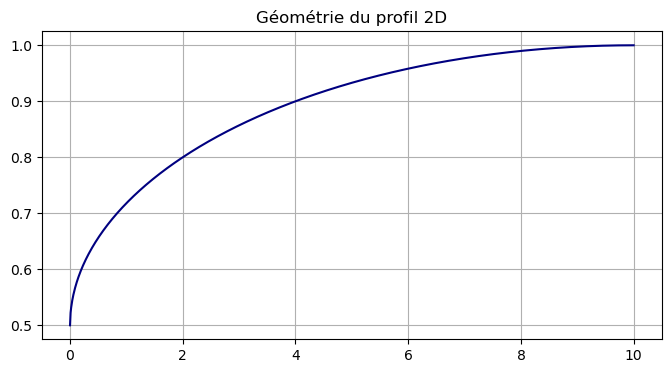

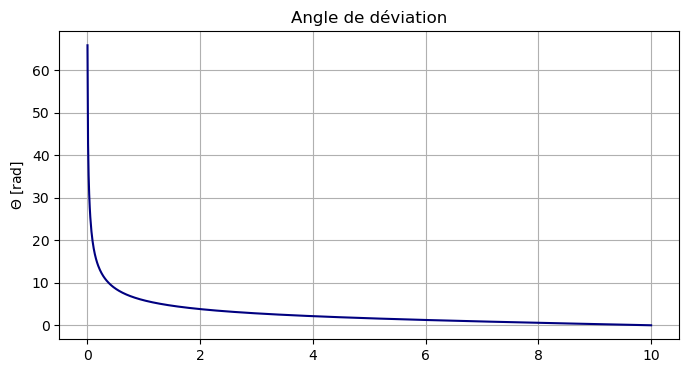

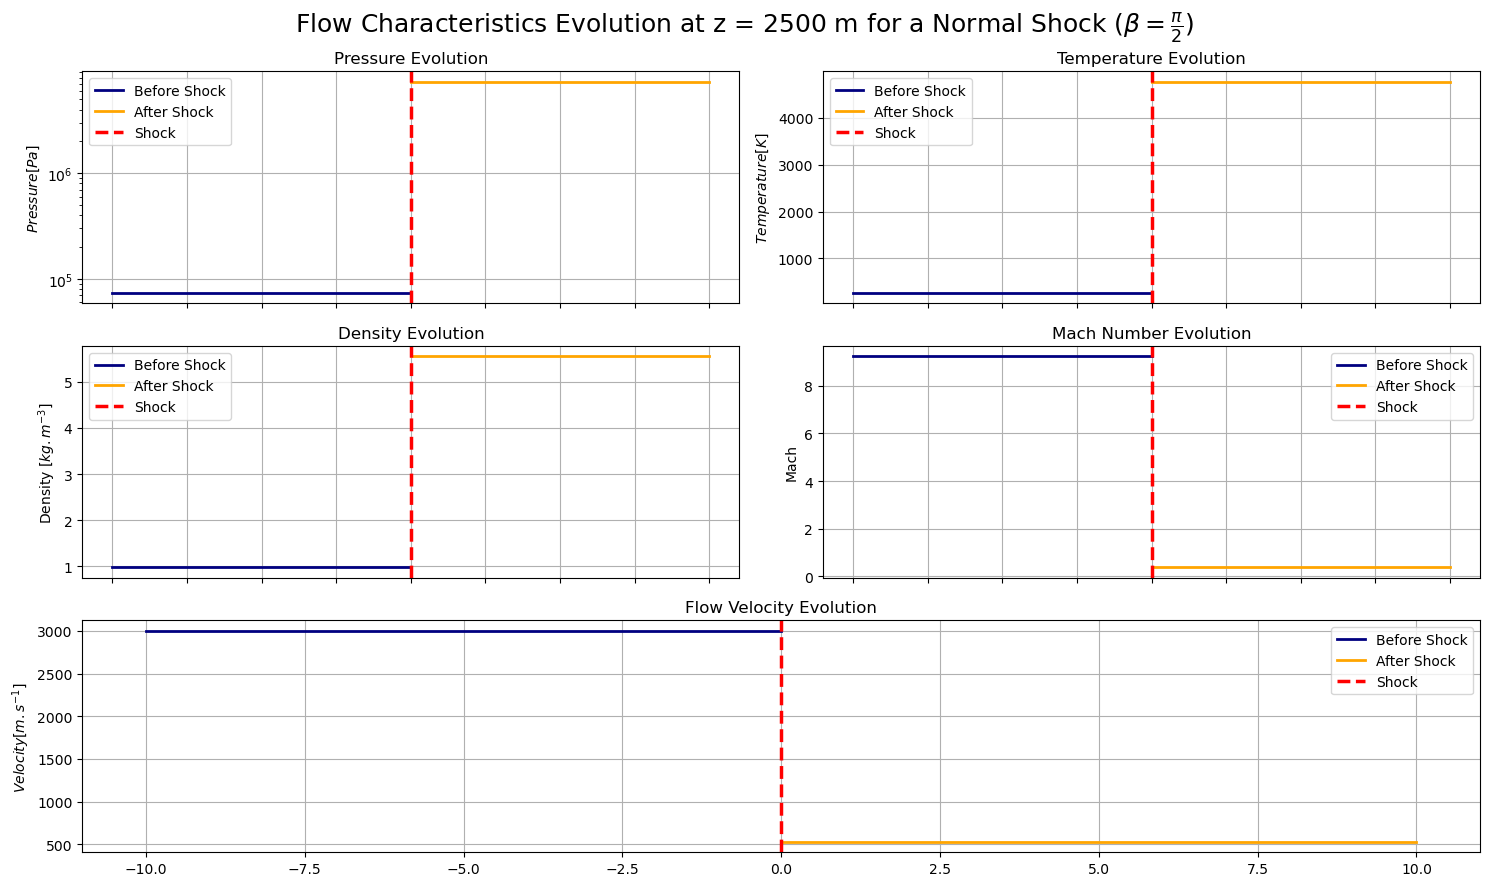

c:\ProgramData\miniconda3\envs\Elisa5\lib\site-packages\scipy\optimize\_zeros_py.py:357: RuntimeWarning: overflow encountered in scalar divide
  p = (-q1 / q0 * p0 + p1) / (1 - q1 / q0)
C:\Users\plamb\AppData\Local\Temp\ipykernel_11272\113499332.py:140: RuntimeWarning: invalid value encountered in cos
  return np.cos(angle)/np.sin(angle)
C:\Users\plamb\AppData\Local\Temp\ipykernel_11272\113499332.py:140: RuntimeWarning: invalid value encountered in sin
  return np.cos(angle)/np.sin(angle)
C:\Users\plamb\AppData\Local\Temp\ipykernel_11272\113499332.py:144: RuntimeWarning: invalid value encountered in sin
  right_side = 2 * cotangent(beta) * ((Mach**2 * np.sin(beta)**2 - 1) / (Mach**2 * (gamma + np.cos(2 * beta)) + 2))
C:\Users\plamb\AppData\Local\Temp\ipykernel_11272\113499332.py:144: RuntimeWarning: invalid value encountered in cos
  right_side = 2 * cotangent(beta) * ((Mach**2 * np.sin(beta)**2 - 1) / (Mach**2 * (gamma + np.cos(2 * beta)) + 2))


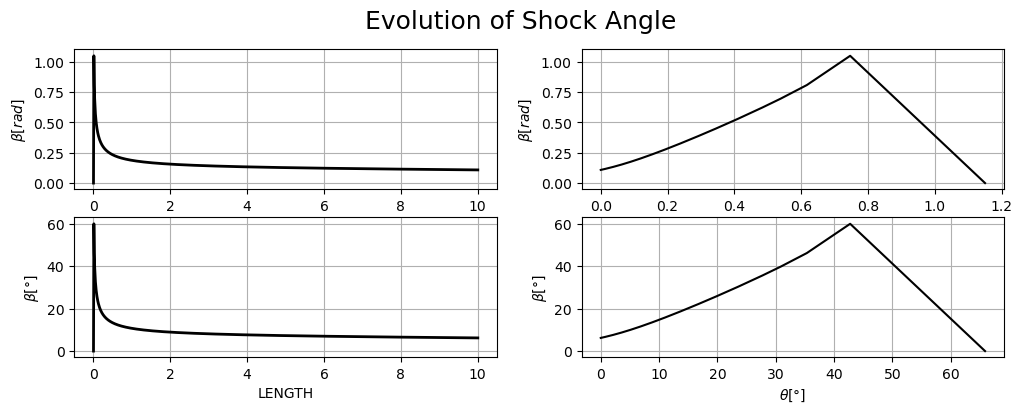

C:\Users\plamb\AppData\Local\Temp\ipykernel_11272\113499332.py:326: RuntimeWarning: divide by zero encountered in scalar divide
  T_AS = (((1 + 0.5 * (gamma - 1) * Mach_n**2) * (((2 * gamma) / (gamma - 1)) * Mach_n**2 - 1)) / (Mach_n**2 * ((gamma + 1)**2/(2 * (gamma - 1))))) * T_z


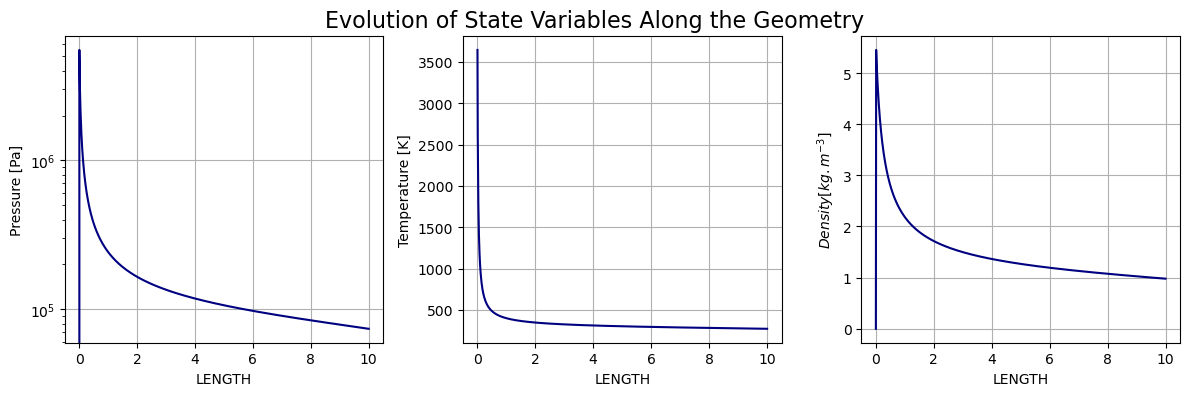

In [45]:
## INITIALISATION

StandardAtm = {
    "Pressure": 101325,
    "Temperature": 288.15,
    "Density": 1.225,
    "Viscosity": 1.458 * 1e-6,
    "Tz": -6.5 * 1e-3,
    "r": 8.314 / (29.966 * 1e-3),
    "g": 9.80665,
    "gamma": 1.4,
}
x = np.linspace(0, 10, 1000)
radius = 0.5
length = 10
y = radius * (1 + np.sqrt(1 - ((length - x) / length)**2)) 

Abaques_path = os.getcwd().replace("src", "Docs\Abaques")
z = 2500
Velocity = 3000

HypSim = HypersonicSimulation(Geometry=y, Length=x, Abaques_path=Abaques_path, altitude=z, StandardAtm=StandardAtm, velocity=Velocity)

In [46]:
# ABACUS
IsentropicFlow, NormalShock, PrandtlMeyer = HypSim.IsentropicFlow, HypSim.NormalShock, HypSim.PrandtlMeyer

# DEVIATION ANGLES
Deviation = HypSim.Deviation

# STATE VARIABLES
StateVar_z, UpstreamStateVar, AfterShockStateVar = HypSim.StateVar_z, HypSim.UpstreamStateVar, HypSim.AfterShockStateVar

# MACH NUMBER
Mach, AfterShockMach = HypSim.Mach, HypSim.AfterShockMach
print(f"Nombre de Mach : {Mach} et nombre de Mach après le choc : {AfterShockMach}")

# VELOCITY
VelocityAfterShock = HypSim.VelocityAfterShock
print(f"Flow velocity after shock : {VelocityAfterShock} m/s")

Nombre de Mach : 9.23128183980908 et nombre de Mach après le choc : 0.3892211602794204
Flow velocity after shock : 529.337019362685 m/s


In [47]:
print(f"State Variables at z = {z} m")
for key, value in StateVar_z.items():
    print(f"    - {key}: {value}")

print("\nIsentropique State Variable at stopping point")
for key, value in UpstreamStateVar.items():
    print(f"    - {key}: {value:.5}")

print(f"\nState Variables after a shock with angle of shock = {np.rad2deg(np.pi/2)} deg ")
for key, value in AfterShockStateVar.items():
    print(f"    - {key}: {value:.5}")

State Variables at z = 2500 m
    - Pressure: 73897.87511615695
    - Temperature: 271.9
    - Density: 0.9795835831136002
    - Viscosity: 1.7098855310161402e-05

Isentropique State Variable at stopping point
    - Pressure: 1.8439e+09
    - Temperature: 4906.0
    - Density: 1354.7

State Variables after a shock with angle of shock = 90.0 deg 
    - Pressure: 7.3346e+06
    - Temperature: 4761.7
    - Density: 5.5518


In [48]:
StateVarObliqueShock = HypSim.StateVarObliqueShock

T_max = np.max(StateVarObliqueShock["Temperature"])
T_min = np.min(StateVarObliqueShock["Temperature"][StateVarObliqueShock["Temperature"] != -np.inf])
Grad_T = (T_min - T_max) / np.max(x)
print(f"Temperature maximale sur le fuselage : {T_max} K")
print(f"Temperature minimal sur le fuselage : {T_min} K")
print(f"Gradient de température entre le début et la fin du fuselage : {Grad_T} K/m")

Temperature maximale sur le fuselage : 3644.41477362929 K
Temperature minimal sur le fuselage : 271.9252742757815 K
Gradient de température entre le début et la fin du fuselage : -337.2489499353508 K/m


In [49]:
P_max = np.max(StateVarObliqueShock["Pressure"])
P_min = np.min(StateVarObliqueShock["Pressure"][(StateVarObliqueShock["Pressure"] > 0)])
Grad_P = (P_min - P_max) / np.max(x)
print(f"Pression maximale sur le fuselage : {P_max} Pa")
print(f"Pression minimal sur le fuselage : {P_min} Pa")
print(f"Gradient de pression entre le début et la fin du fuselage : {Grad_P} Pa/m")

Pression maximale sur le fuselage : 5512836.0857064575 Pa
Pression minimal sur le fuselage : 73921.91984944743 Pa
Gradient de pression entre le début et la fin du fuselage : -543891.416585701 Pa/m


In [50]:
rho_max = np.max(StateVarObliqueShock["Density"])
rho_min = np.min(StateVarObliqueShock["Density"][(StateVarObliqueShock["Density"] > 0)])
Grad_rho = (rho_min - rho_max) / np.max(x)
print(f"Densité maximale sur le fuselage : {rho_max} (kg/m^3)")
print(f"Densité minimal sur le fuselage : {rho_min} (kg/m^3)")
print(f"Gradient de densité entre le début et la fin du fuselage : {Grad_rho} (kg/m^3)/m")

Densité maximale sur le fuselage : 5.452127911749128 (kg/m^3)
Densité minimal sur le fuselage : 0.9798112402607448 (kg/m^3)
Gradient de densité entre le début et la fin du fuselage : -0.4472316671488382 (kg/m^3)/m
